## Aircraft Detection - Deep Learning Project

In [1]:
import os
import json
import random
import pandas as pd
import skimage.io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
data_root = os.getcwd()
print(data_root)
#r"D:\RarePlanes\data"
train_imgs = os.path.join(data_root, r'C:\Users\artur\Documents\GitHub\aircraft-detection\data\train')
annot_dir = os.path.join(data_root, r'C:\Users\artur\Documents\GitHub\aircraft-detection\data\annot\rareplanes.json')
train_im_list = [z for z in os.listdir(train_imgs) if z.endswith('.png')]
f = open(annot_dir)
data = json.load(f)
print(len(train_im_list))
print(len(data['images']))
assert len(train_im_list) == len(data['images'])

def imgs_annot_aggregator(iter):
    print("Running imgs_annot_aggregator...")
    final = np.zeros((iter,4))
    bounding_boxes = []
    image_names = []
    instances_img = []
    amount_matches = []
    class_type = []
    for j in range(iter): 
        instances_img = []                        
        img = random.sample(train_im_list,1)
        image_names.append(img[0])
        for i in range(len(data['categories'])):
            if [data['categories'][i]['image_fname']] == img:
                instances_img.append(data['categories'][i]['id'])
        for l in range(len(instances_img)):
            for i in range(len(data['categories'])):
                if data['categories'][i]['id'] == instances_img[l]:
                    bounding_boxes.append(data['categories'][i]['bbox'])
                    class_type.append(data['categories'][i]['role'])
        amount_matches.append(len(instances_img))
    final = amount_matches, image_names, bounding_boxes, class_type
    return final, image_names

def bbox_points(data_annot):
    print("Running bbox_points...")
    name = []
    x_org = []
    y_org = []
    x_dist = []
    y_dist = []
    bbox = []
    class_type = []
    file_path = []
    itr = 0
    for i in range(len(data_annot[0])):
        for j in range(data_annot[0][i]):
            name.append(data_annot[1][i])
            class_type.append(data_annot[3][i])
            x_org.append(data_annot[2][j+itr][0])
            y_org.append(data_annot[2][j+itr][1])
            x_dist.append(data_annot[2][j+itr][2])
            y_dist.append(data_annot[2][j+itr][3])
            bbox.append([data_annot[2][j+itr][0],data_annot[2][j+itr][1],data_annot[2][j+itr][0]+data_annot[2][j+itr][2],data_annot[2][j+itr][1]+data_annot[2][j+itr][3]])
            file_path.append(os.path.join(train_imgs, data_annot[1][i]))
        itr = itr + data_annot[0][i]
    df = pd.DataFrame(
    {'name': name,
     'class': class_type,
     'x_org': x_org,
     'y_org': y_org,
     'x_dist': x_dist,
     'y_dist': y_dist,
     'bbox': bbox,
     'file_path': file_path
    })
    return df

final, img_name = imgs_annot_aggregator(1)
result = bbox_points(final)
result.head()

c:\Users\artur\Documents\GitHub\aircraft-detection\src
5815
5815
Running imgs_annot_aggregator...
Running bbox_points...


,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,31_104001002809DA00_tile_540.png,Large Civil Transport/Utility,0.000000,206.643100,122.689510,165.648365,"[0.0, 206.6431001527235, 122.68950996175408, 3...",C:\Users\artur\Documents\GitHub\aircraft-detec...
1,31_104001002809DA00_tile_540.png,Large Civil Transport/Utility,104.623138,348.651294,131.754308,118.489359,"[104.62313795089722, 348.6512944800779, 236.37...",C:\Users\artur\Documents\GitHub\aircraft-detec...


## Testing random images

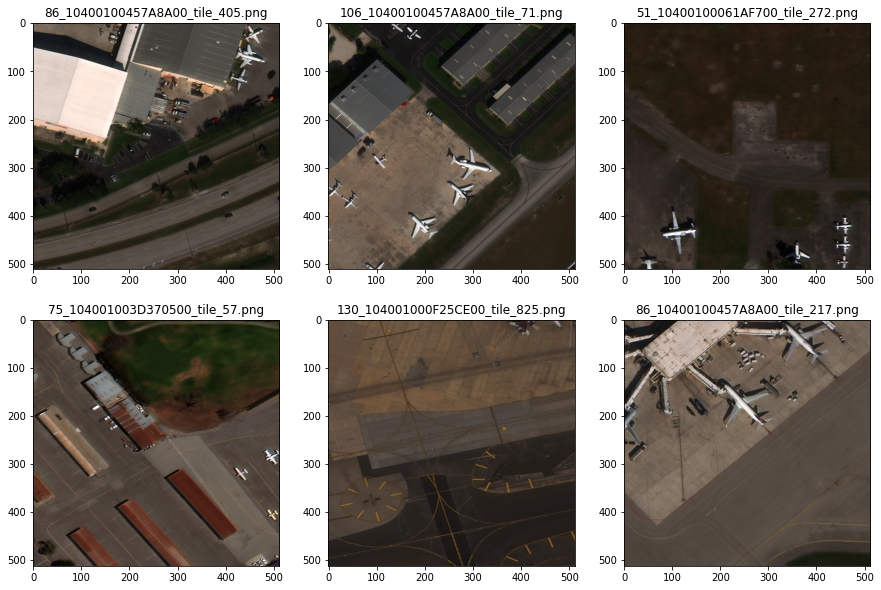

In [3]:
dir_tmp = train_imgs
rows, cols = 2, 3
figsize = 5
rand_selection = random.sample(train_im_list, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize*cols, figsize*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = os.path.join(train_imgs, rand_selection[i])
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

# Loading the entire Dataset

In [4]:
print(len(train_im_list))
amount_imgs = 100

final_data, img_name_data = imgs_annot_aggregator(amount_imgs)#len(train_im_list))
result_data = bbox_points(final_data)

print(np.shape(result_data))

result_data.head()

5815
Running imgs_annot_aggregator...
Running bbox_points...
(344, 8)


,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,53_1040010008249C00_tile_151.png,Military Transport/Utility/AWAC,0.000000,447.808994,49.952384,64.191006,"[0.0, 447.80899432860315, 49.95238361135125, 5...",C:\Users\artur\Documents\GitHub\aircraft-detec...
1,106_1040010044D30600_tile_55.png,Small Civil Transport/Utility,0.972480,497.646406,21.011190,14.353594,"[0.9724804721772671, 497.646406205371, 21.9836...",C:\Users\artur\Documents\GitHub\aircraft-detec...
2,106_1040010044D30600_tile_55.png,Small Civil Transport/Utility,210.531651,31.710115,47.680361,42.654226,"[210.531650736928, 31.71011495217681, 258.2120...",C:\Users\artur\Documents\GitHub\aircraft-detec...
3,106_1040010044D30600_tile_55.png,Small Civil Transport/Utility,468.766312,38.773872,41.567494,35.997993,"[468.7663124501705, 38.7738721370697, 510.3338...",C:\Users\artur\Documents\GitHub\aircraft-detec...
4,84_10400100290F5300_tile_184.png,Medium Civil Transport/Utility,3.393706,173.129856,39.081799,36.707671,"[3.3937063552439213, 173.12985632382333, 42.47...",C:\Users\artur\Documents\GitHub\aircraft-detec...


In [5]:
class_dict = {'Small Civil Transport/Utility': 0, 
              'Medium Civil Transport/Utility': 1, 
              'Large Civil Transport/Utility': 2, 
              "Military Transport/Utility/AWAC": 3,
              "Military Fighter/Interceptor/Attack": 4,
              "Military Bomber": 5,
              "Military Trainer": 6
              }

result_data['class'] = result_data['class'].apply(lambda x: class_dict[x])

In [6]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros([rows,cols])
    bb = bb.astype(int)
    Y[bb[1]:(bb[1]+bb[3]),bb[0]:(bb[0]+bb[2])] = 1.
    return Y

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[2],x[3],x[4],x[5]])

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

# Visualize Masks

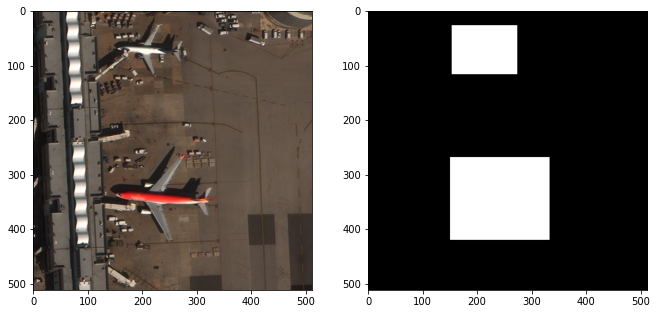

In [7]:
row = int(np.random.uniform(low=0, high=100, size=(1,)))

test_img = os.path.join(train_imgs, str(result_data['name'][row]))
rows_image = []

for i in range(100):    #len(train_im_list)):
    if result_data['name'][i] == result_data['name'][row]:
        rows_image.append(i)

im = skimage.io.imread(test_img)
bb = []
final_y = np.zeros((512,512))

for i in range(len(rows_image)):
    bb.append(create_bb_array(result_data.values[rows_image[i]]))
    Y = create_mask(bb[i],im)
    final_y = np.where(final_y == 0, Y, final_y)

figsize = 11
f, axarr = plt.subplots(1,2,figsize=(figsize*1, figsize*2))
axarr[0].imshow(im)
axarr[1].imshow(final_y, cmap='gray')

# Data Augmentation

In [8]:
new_size = 128
ratio = int(512/new_size)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    x = cv2.resize(x,(new_size,new_size) ) 
    bb[0] = int(bb[0]/ratio)
    bb[1] = int(bb[1]/ratio)
    bb[2] = int(bb[2]/ratio)
    bb[3] = int(bb[3]/ratio)
    return x, bb 

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=1)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))


In [9]:
result_data.head()

,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,53_1040010008249C00_tile_151.png,3,0.000000,447.808994,49.952384,64.191006,"[0.0, 447.80899432860315, 49.95238361135125, 5...",C:\Users\artur\Documents\GitHub\aircraft-detec...
1,106_1040010044D30600_tile_55.png,0,0.972480,497.646406,21.011190,14.353594,"[0.9724804721772671, 497.646406205371, 21.9836...",C:\Users\artur\Documents\GitHub\aircraft-detec...
2,106_1040010044D30600_tile_55.png,0,210.531651,31.710115,47.680361,42.654226,"[210.531650736928, 31.71011495217681, 258.2120...",C:\Users\artur\Documents\GitHub\aircraft-detec...
3,106_1040010044D30600_tile_55.png,0,468.766312,38.773872,41.567494,35.997993,"[468.7663124501705, 38.7738721370697, 510.3338...",C:\Users\artur\Documents\GitHub\aircraft-detec...
4,84_10400100290F5300_tile_184.png,1,3.393706,173.129856,39.081799,36.707671,"[3.3937063552439213, 173.12985632382333, 42.47...",C:\Users\artur\Documents\GitHub\aircraft-detec...


C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\112_104001001FBAB400_tile_204.png


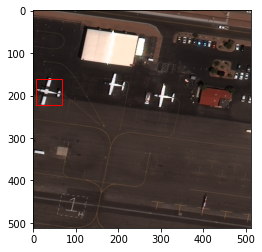

In [10]:
pic = int(np.random.uniform(low=0.0, high=100, size=None))

print(result_data['file_path'][pic])

im = cv2.imread(str(result_data['file_path'][pic]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, result_data['bbox'][pic])

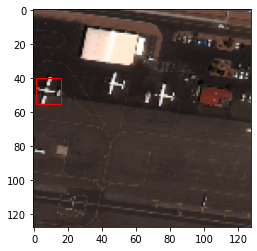

In [11]:
im, bb = transformsXY(str(result_data['file_path'][pic]), np.array(result_data['bbox'][pic],dtype=np.int32),True)
show_corner_bb(im, bb)

# Training


In [12]:
result_data = result_data.reset_index()

In [14]:
X = result_data[['file_path','bbox']]
Y = result_data['class']

X.head()

,file_path,bbox
0,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[0.0, 447.80899432860315, 49.95238361135125, 5..."
1,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[0.9724804721772671, 497.646406205371, 21.9836..."
2,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[210.531650736928, 31.71011495217681, 258.2120..."
3,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[468.7663124501705, 38.7738721370697, 510.3338..."
4,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[3.3937063552439213, 173.12985632382333, 42.47..."


In [15]:
Y.head() 

0    3
1    0
2    0
3    0
4    1
Name: class, dtype: int64

# Pre Processing

#### Test image (reduced)

In [16]:
import warnings
import BBOX
warnings.simplefilter(action='ignore', category=FutureWarning)

def image_merger(result_data):
    final_data_frame = pd.DataFrame()
    print("Original length of result_data: ",len(result_data['file_path']))
    imgs_used = []

    for i in range(len(result_data['file_path'])):
        checker = True
        img_path_test = result_data['file_path'][i]

        for x in range(len(imgs_used)):
            if imgs_used[x] == img_path_test:
                checker = False
        
        if checker == True:
            imgs_used.append(img_path_test)
            indx_number = []

            for j in range(len(result_data['file_path'])):
                if img_path_test == result_data['file_path'][j]:
                    indx_number.append(j)

            final_bbxs = []
            for h in range(len(indx_number)):
                bbox = result_data['bbox'][indx_number[h]]
                final_bbxs.append(BBOX.BBOX(bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[0]))
            
            final_data_frame = final_data_frame.append({'path': img_path_test, 'final_bbx': final_bbxs}, ignore_index=True)

    return final_data_frame

df_final = image_merger(result_data)
df_final.head()


print(len(df_final['final_bbx'][0]))
print(df_final['path'][1])

Original length of result_data:  344
1
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\106_1040010044D30600_tile_55.png


### Function that generates bbox's based on a center point

7500


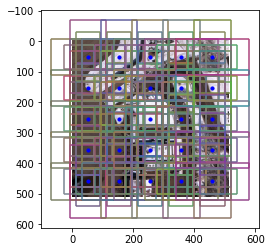

In [17]:
import BBOX

img_test_path_curr = df_final['path'][0]

import importlib
importlib.reload(BBOX)

bboxes = BBOX.generate(5, 130, 40, img_test_path_curr)
print(len(bboxes))
BBOX.display(bboxes, img_test_path_curr, 5)

### IoU - Interception over Union

In [23]:

def iou(boxA, boxB):
    xA = max(boxA.arr[0], boxB.arr[0])
    yA = max(boxA.arr[1], boxB.arr[1])
    xB = min(boxA.arr[2], boxB.arr[2])
    yB = min(boxA.arr[3], boxB.arr[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA.arr[2] - boxA.arr[0] + 1) * (boxA.arr[3] - boxA.arr[1] + 1)
    boxBArea = (boxB.arr[2] - boxB.arr[0] + 1) * (boxB.arr[3] - boxB.arr[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

rec1 = BBOX.BBOX(120,120,60,60)
rec2 = BBOX.BBOX(120,120,60,60)

result_iou = iou(rec1,rec2) 
print(result_iou)

1.0


In [19]:
def app_flat(my_array):
    out = np.zeros_like(my_array)
    idx  = my_array.argmax()
    out.flat[idx] = 1
    return out

In [34]:
import BBOX

def get_vectors_mask_wise(df_final):
    for_real_tho = pd.DataFrame()
    
    img_test_path_curr = df_final['path'][0]
    bboxs = BBOX.generate(5, 130, 40, img_test_path_curr)

    for l in range(len(df_final['path'])):
        img_test_path_curr = df_final['path'][l]

        masks = df_final['final_bbx'][l]
        vector_f = np.empty([np.shape(bboxs)[0],])

        print("Image number: ", l)

        for i in range(len(masks)):
            temp_vector = []
            for j in range(len(bboxs)):
                value = iou(masks[i],bboxs[j])
                temp_vector.append(value)
            temp_vector = np.array(temp_vector)
            return_temp_vector = app_flat(temp_vector) 
            print(sum(return_temp_vector))

            vector_f = vector_f + return_temp_vector

        for_real_tho = for_real_tho.append({'path': img_test_path_curr, 'vector': vector_f}, ignore_index=True)

    return for_real_tho

for_real_tho = get_vectors_mask_wise(df_final)


Image number:  0
1.0
Image number:  1
1.0
1.0
1.0
Image number:  2
1.0
1.0
1.0
1.0
1.0
Image number:  3
1.0
Image number:  4
1.0
Image number:  5
1.0
Image number:  6
1.0
Image number:  7
1.0
Image number:  8
1.0
Image number:  9
1.0
1.0
Image number:  10
1.0
1.0
1.0
1.0
1.0
Image number:  11
1.0
Image number:  12
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Image number:  13
1.0
1.0
Image number:  14
1.0
1.0
Image number:  15
1.0
1.0
Image number:  16
1.0
Image number:  17
1.0
1.0
Image number:  18
1.0
1.0
1.0
1.0
1.0
1.0
Image number:  19
1.0
Image number:  20
1.0
Image number:  21
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Image number:  22
1.0
1.0
1.0
Image number:  23
1.0
Image number:  24
1.0
Image number:  25
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Image number:  26
1.0
Image number:  27
1.0
1.0
1.0
1.0
Image number:  28
1.0
Image number:  29
1.0
Image number:  30
1.0
Image number:  31
1.0
Image number:  32
1.0
1.0
1.0
Image number:  33
1.0
1.0
1.0
1.0
1.0
1.0
1.

In [33]:
for_real_tho.head()

# print(for_real_tho['path'][2])

,path,vector
0,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[1.1064493820273e-311, 1.1065768293594e-311, 1..."
1,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[2.0, 1.1065768293594e-311, 1.1062719143904e-3..."
2,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[3.0, 1.1065768293594e-311, 1.1062719143904e-3..."
3,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[1.106329230116e-311, 1.1065768293594e-311, 1...."
4,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[1.1063292597677e-311, 1.1065768293594e-311, 1..."


# Training

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
class AircraftDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        y_bb = self.bb[idx]
        x = self.paths
        x, y_bb = transformsXY(str(path), np.array(self.bb[idx],dtype=np.int32), True)
        x.transpose(1, 0, 2).strides        
        return x, y_class, y_bb

In [ ]:
train_ds = AircraftDataset(X_train['file_path'],X_train['bbox'] ,y_train, transforms=True)
valid_ds = AircraftDataset(X_val['file_path'],X_val['bbox'],y_val)

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)


In [ ]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        # resnet = models.resnet34(pretrained=True)
        # layers = list(resnet.children())[:8]
        # self.features1 = nn.Sequential(*layers[:6])
        # self.features2 = nn.Sequential(*layers[6:])
        self.conv1 = nn.Conv2d(3,6,3)
        self.classifier = nn.Sequential(nn.BatchNorm1d(6), nn.Linear(6, 7))
        self.bb = nn.Sequential(nn.BatchNorm1d(6), nn.Linear(6, 4))
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

model = create_model(7)
print(model)

In [ ]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [ ]:
def val_metrics(model, valid_dl, C=1000):
    count = 0
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        print('Inside loop (val): ',count)
        batch = y_class.shape[0]
        x = x.float()
        x = torch.permute(x, (0, 3, 1, 2))
        y_class = y_class
        y_bb = y_bb.float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
        count = count + 1 
    return sum_loss/total, correct/total

def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    count = 0
    for i in range(epochs):
        print('Epoch number (train)',i,' of ', epochs)
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            print('Inside loop: ',count)
            batch = y_class.shape[0]
            x = x.float()
            y_class = y_class
            y_bb = y_bb.float()
            x = torch.permute(x, (0, 3, 1, 2))
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
            count = count + 1 
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [ ]:
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [ ]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=2)